In [32]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import MultipleLocator
from tqdm import tqdm
import seaborn as sns; sns.set()
sns.__version__

'0.11.1'

In [5]:
sns.set_style("ticks", {"xtick.major.size":15,"ytick.major.size":15})

plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

%config InlineBackend.figure_format = 'retina'

In [6]:
df_paper_1985_2009 = pd.read_pickle("/data/interdisciplinarity/df_paper_1985_2009.pkl")

In [7]:
df_paper_1985_2009['mag_id'] = df_paper_1985_2009['mag_id'].apply(str)
df_paper_1985_2009.dtypes

mag_id                                       object
num_reference                                 int64
num_citation                                  int64
multidisciplinarity_reference               float64
interdisciplinarity_reference               float64
multidisciplinarity_citation                float64
interdisciplinarity_citation                float64
crossdisciplinarity                         float64
pub_year                                      int64
paper_fos                                   float64
c_percentile_lvl-0                          float64
disruption                                  float64
d_percentile                                float64
c10                                         float64
norm_c10_year                               float64
norm_c10_fos                                float64
norm_c10_year_fos                           float64
c_percentile_lvl-1                          float64
grant_status                                  int64
interdiscipl

In [ ]:
"""
Authors.txt
names=["author_id", "rank", "normalized_name", "display_name", "last_affiliation_id", "paper_count", "citation_count", "created_at"]
                         
PaperAuthorAffiliations.txt
names=["paper_id", "author_id", "affiliation_id", "author_order", "affiliation_name"]
"""

In [35]:
df_authors = pd.read_csv("/data/sci_of_sci/MAG_2019_12/Authors.txt", sep='\t',
                         names=["author_id", "rank", "normalized_name", "display_name", "last_affiliation_id", "paper_count", "citation_count", "created_at"])

In [39]:
tmp = df_authors[['author_id','citation_count']].copy()
tmp['author_id'] = tmp['author_id'].apply(str)
d_author2citations = dict(zip(tmp['author_id'], tmp['citation_count']))

In [51]:
import pickle

DIR = '/data/interdisciplinarity/'
with open(DIR + 'd_author2citations.pkl', 'wb') as outfile:
    pickle.dump(d_author2citations, outfile)

In [ ]:
DIR = '/data/interdisciplinarity/'
with open(DIR + 'd_author2citations.pkl', 'rb') as infile:
    d_author2citations = pickle.loads(infile.read())

In [48]:
counter_f = 0
counter_a = 0
d_paper2author = {}
with open('/data/sci_of_sci/MAG_2019_12/PaperAuthorAffiliations.txt', 'r') as f:
    for line in tqdm(f, total=616207480):
        fields = line.split('\t')
        if len(fields) != 6:
            counter += 1
        
        mag_id = str(fields[0])
        author_id = str(fields[1])
        if mag_id not in d_paper2author:
            d_paper2author[mag_id] = {}
            if author_id in d_author2citations:
                d_paper2author[mag_id][author_id] = d_author2citations[author_id]
            else:
                d_paper2author[mag_id][author_id] = None
                counter_a += 1
        else:
            if author_id in d_author2citations:
                d_paper2author[mag_id][author_id] = d_author2citations[author_id]
            else:
                d_paper2author[mag_id][author_id] = None
                counter_a += 1

100%|██████████| 616207480/616207480 [23:03<00:00, 445270.16it/s] 


In [52]:
import pickle

DIR = '/data/interdisciplinarity/'
with open(DIR + 'd_paper2authors.pkl', 'wb') as outfile:
    pickle.dump(d_paper2author, outfile)

In [ ]:
DIR = '/data/interdisciplinarity/'
with open(DIR + 'd_paper2authors.pkl', 'rb') as infile:
    d_paper2author = pickle.loads(infile.read())

In [112]:
d_paper2author_max_citation = {}
for k,v in tqdm(d_paper2author.items()):
    try:
        d_paper2author_max_citation[k] = max([i for i in [*v.values()] if i != None])
    except:
        d_paper2author_max_citation[k] = np.nan

100%|██████████| 230570323/230570323 [04:22<00:00, 879561.08it/s] 


In [56]:
tmp = df_paper_1985_2009[['mag_id','grant_status','pub_year',
                          'interdisciplinarity_reference','interdisciplinarity_citation',]].copy()

In [59]:
tmp['num_author'] = tmp['mag_id'].apply(lambda x: d_paper2author.get(x)).str.len()

In [113]:
tmp['max_citation'] = tmp['mag_id'].map(d_paper2author_max_citation)

In [123]:
def createList(r1, r2, interval):
    return np.arange(r1, r2+interval, interval)

tmp['num_author_percentile'] = tmp['num_author'].rank(pct=True)

c = pd.cut(
    tmp['num_author_percentile'],
    list(createList(0.0,1.0,0.25)),
    labels=list(createList(0,100,25))[1:]
)

tmp['num_author_interval'] = c

In [125]:
tmp['max_citation_percentile'] = tmp['max_citation'].rank(pct=True)

c = pd.cut(
    tmp['max_citation_percentile'],
    list(createList(0.0,1.0,0.25)),
    labels=list(createList(0,100,25))[1:]
)

tmp['max_citation_interval'] = c

In [122]:
from scipy.stats import pearsonr

x = tmp[['num_author','max_citation']].dropna()
pearsonr(x['num_author'],x['max_citation'])

(0.19470524767421057, 0.0)

In [115]:
import pickle

DIR = '/data/interdisciplinarity/'
with open(DIR + 'df_paper2author_prominence.pkl', 'wb') as outfile:
    pickle.dump(tmp, outfile)

In [ ]:
DIR = '/data/interdisciplinarity/'
with open(DIR + 'df_paper2author_prominence.pkl', 'rb') as infile:
    tmp = pickle.loads(infile.read())

In [116]:
# Source: http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_%28ggplot2%29/
# Produces count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   conf_interval: the percent range of the confidence interval (default is 95%)

import scipy as sp
from scipy.stats import t

def summarySE(data, measurevar, groupvars, conf_interval=0.95):
    def std(s):
        return np.std(s, ddof=1)
    def stde(s):
        return std(s) / np.sqrt(len(s))
    def ci(s):
        # Confidence interval multiplier for standard error
        # Calculate t-statistic for confidence interval: 
        # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
        ciMult = t.ppf(conf_interval/2.0 + .5, len(s)-1)
        return stde(s)*ciMult
    def ciUpper(s):
        return np.mean(s)+ci(s)
    def ciLower(s):
        return np.mean(s)-ci(s)
    
    data = data[groupvars+measurevar].groupby(groupvars).agg([len, np.mean, std, stde, ciUpper, ciLower, ci])

    data.reset_index(inplace=True)

    data.columns = groupvars+['_'.join(col).strip() for col in data.columns.values[len(groupvars):]]

    return data

## Supplementary Fig.X

In [144]:
paperITDref_per_year_grant_teamSize = summarySE(tmp, ['interdisciplinarity_reference'],
                                                ['grant_status','pub_year','num_author_interval'])

paperITDref_per_year_grant_maxCitation = summarySE(tmp, ['interdisciplinarity_reference'],
                                                   ['grant_status','pub_year','max_citation_interval'])

paperITDcit_per_year_grant_teamSize = summarySE(tmp, ['interdisciplinarity_citation'],
                                                ['grant_status','pub_year','num_author_interval'])

paperITDcit_per_year_grant_maxCitation = summarySE(tmp, ['interdisciplinarity_citation'],
                                                   ['grant_status','pub_year','max_citation_interval'])

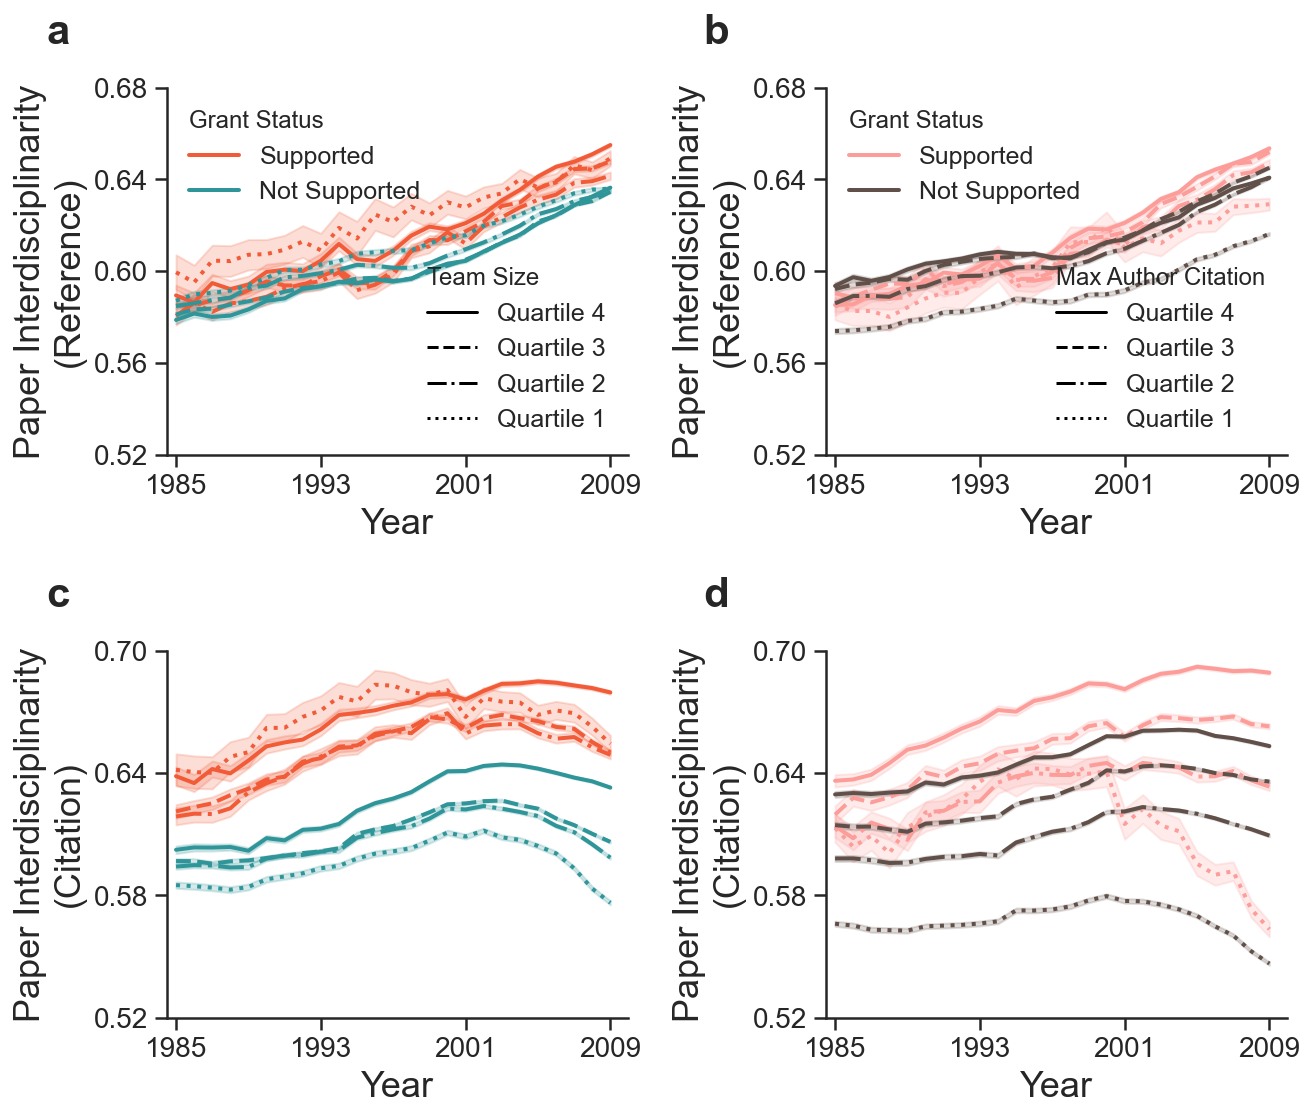

In [272]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(14*(2/3),4*2))
gs_ = GridSpec(2, 2, figure=fig)

l_color_1 = ["#F25B38", "#2F9599"]
l_color_2 = ["#FC9D9A", "#615049"]
l_line = ['-', '--', '-.', ':']

grant_status = [1,0]
l_label_gs = ['Supported','Not Supported']

team_prominence = [100,75,50,25]
l_label_tp = ['Quartile 4','Quartile 3','Quartile 2','Quartile 1']

#####----- A -----#####
ax = fig.add_subplot(gs_[0,0])

for i,gs in enumerate(grant_status):
    
    for j,tp in enumerate(team_prominence):
        label_tp = 'Quartile {}'.format(j+1)
        
        x = paperITDref_per_year_grant_teamSize[(paperITDref_per_year_grant_teamSize['grant_status']==grant_status[i]) &\
                                                (paperITDref_per_year_grant_teamSize['num_author_interval']==team_prominence[j])
                                               ]['pub_year']
        mu = paperITDref_per_year_grant_teamSize[(paperITDref_per_year_grant_teamSize['grant_status']==grant_status[i]) &\
                                                (paperITDref_per_year_grant_teamSize['num_author_interval']==team_prominence[j])
                                               ]['interdisciplinarity_reference_mean']
        ci = paperITDref_per_year_grant_teamSize[(paperITDref_per_year_grant_teamSize['grant_status']==grant_status[i]) &\
                                                (paperITDref_per_year_grant_teamSize['num_author_interval']==team_prominence[j])
                                               ]['interdisciplinarity_reference_ci']
        
        ax.plot(x, mu, lw=2, color=l_color_1[i], linestyle=l_line[j])
        ax.fill_between(x, mu+ci, mu-ci, facecolor='C{}'.format(i), alpha=0.2, color=l_color_1[i])

dummy_lines = []
for b_idx, b in enumerate(team_prominence):
    dummy_lines.append(ax.plot([],[], color="black", linestyle=l_line[b_idx])[0])
lines = ax.get_lines()
l1 = plt.legend([lines[i] for i in [0,4]], l_label_gs, title='Grant Status',
                loc='upper left', fontsize=12.5, frameon=False)
l1._legend_box.align = "left"
l2 = plt.legend([dummy_lines[i] for i,k in enumerate(team_prominence)], l_label_tp, title='Team Size',
                loc='lower right', fontsize=12.5, frameon=False)
l2._legend_box.align = "left"
ax.add_artist(l1)
        
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks([0.52, 0.56, 0.60, 0.64, 0.68])
ax.set_yticklabels(['0.52', '0.56', '0.60', '0.64', '0.68'])
plt.ylim(0.52, 0.68)
plt.xticks([1985, 1993, 2001, 2009])
ax.set_xticklabels(['1985', '1993', '2001', '2009'])
plt.xlim(1984.5, 2010)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'a', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- B -----#####
ax = fig.add_subplot(gs_[0,1])

for i,gs in enumerate(grant_status):
    
    for j,tp in enumerate(team_prominence):
        label_tp = 'Quartile {}'.format(j+1)
        
        x = paperITDref_per_year_grant_maxCitation[(paperITDref_per_year_grant_maxCitation['grant_status']==grant_status[i]) &\
                                                   (paperITDref_per_year_grant_maxCitation['max_citation_interval']==team_prominence[j])
                                                  ]['pub_year']
        mu = paperITDref_per_year_grant_maxCitation[(paperITDref_per_year_grant_maxCitation['grant_status']==grant_status[i]) &\
                                                    (paperITDref_per_year_grant_maxCitation['max_citation_interval']==team_prominence[j])
                                                   ]['interdisciplinarity_reference_mean']
        ci = paperITDref_per_year_grant_maxCitation[(paperITDref_per_year_grant_maxCitation['grant_status']==grant_status[i]) &\
                                                    (paperITDref_per_year_grant_maxCitation['max_citation_interval']==team_prominence[j])
                                                   ]['interdisciplinarity_reference_ci']
        
        ax.plot(x, mu, lw=2, color=l_color_2[i], linestyle=l_line[j])
        ax.fill_between(x, mu+ci, mu-ci, facecolor='C{}'.format(i), alpha=0.2, color=l_color_2[i])

dummy_lines = []
for b_idx, b in enumerate(team_prominence):
    dummy_lines.append(ax.plot([],[], color="black", linestyle=l_line[b_idx])[0])
lines = ax.get_lines()
l1 = plt.legend([lines[i] for i in [0,4]], l_label_gs, title='Grant Status',
                loc='upper left', fontsize=12.5, frameon=False)
l1._legend_box.align = "left"
l2 = plt.legend([dummy_lines[i] for i,k in enumerate(team_prominence)], l_label_tp, title='Max Author Citation',
                loc='lower right', fontsize=12.5, frameon=False)
l2._legend_box.align = "left"
ax.add_artist(l1)
        
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Paper Interdisciplinarity\n(Reference)', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks([0.52, 0.56, 0.60, 0.64, 0.68])
ax.set_yticklabels(['0.52', '0.56', '0.60', '0.64', '0.68'])
plt.ylim(0.52, 0.68)
plt.xticks([1985, 1993, 2001, 2009])
ax.set_xticklabels(['1985', '1993', '2001', '2009'])
plt.xlim(1984.5, 2010)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'b', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- C -----#####
ax = fig.add_subplot(gs_[1,0])

for i,gs in enumerate(grant_status):
    
    for j,tp in enumerate(team_prominence):
        label_tp = 'Quartile {}'.format(j+1)
        
        x = paperITDcit_per_year_grant_teamSize[(paperITDcit_per_year_grant_teamSize['grant_status']==grant_status[i]) &\
                                                (paperITDcit_per_year_grant_teamSize['num_author_interval']==team_prominence[j])
                                               ]['pub_year']
        mu = paperITDcit_per_year_grant_teamSize[(paperITDcit_per_year_grant_teamSize['grant_status']==grant_status[i]) &\
                                                (paperITDcit_per_year_grant_teamSize['num_author_interval']==team_prominence[j])
                                               ]['interdisciplinarity_citation_mean']
        ci = paperITDcit_per_year_grant_teamSize[(paperITDcit_per_year_grant_teamSize['grant_status']==grant_status[i]) &\
                                                (paperITDcit_per_year_grant_teamSize['num_author_interval']==team_prominence[j])
                                               ]['interdisciplinarity_citation_ci']
        
        ax.plot(x, mu, lw=2, color=l_color_1[i], linestyle=l_line[j])
        ax.fill_between(x, mu+ci, mu-ci, facecolor='C{}'.format(i), alpha=0.2, color=l_color_1[i])
        
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Paper Interdisciplinarity\n(Citation)', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks([0.52, 0.58, 0.64, 0.70])
ax.set_yticklabels(['0.52', '0.58', '0.64', '0.70'])
plt.ylim(0.52, 0.70)
plt.xticks([1985, 1993, 2001, 2009])
ax.set_xticklabels(['1985', '1993', '2001', '2009'])
plt.xlim(1984.5, 2010)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'c', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####----- D -----#####
ax = fig.add_subplot(gs_[1,1])

for i,gs in enumerate(grant_status):
    
    for j,tp in enumerate(team_prominence):
        label_tp = 'Quartile {}'.format(j+1)
        
        x = paperITDcit_per_year_grant_maxCitation[(paperITDcit_per_year_grant_maxCitation['grant_status']==grant_status[i]) &\
                                                   (paperITDcit_per_year_grant_maxCitation['max_citation_interval']==team_prominence[j])
                                                  ]['pub_year']
        mu = paperITDcit_per_year_grant_maxCitation[(paperITDcit_per_year_grant_maxCitation['grant_status']==grant_status[i]) &\
                                                    (paperITDcit_per_year_grant_maxCitation['max_citation_interval']==team_prominence[j])
                                                   ]['interdisciplinarity_citation_mean']
        ci = paperITDcit_per_year_grant_maxCitation[(paperITDcit_per_year_grant_maxCitation['grant_status']==grant_status[i]) &\
                                                    (paperITDcit_per_year_grant_maxCitation['max_citation_interval']==team_prominence[j])
                                                   ]['interdisciplinarity_citation_ci']
        
        ax.plot(x, mu, lw=2, color=l_color_2[i], linestyle=l_line[j])
        ax.fill_between(x, mu+ci, mu-ci, facecolor='C{}'.format(i), alpha=0.2, color=l_color_2[i])
        
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Paper Interdisciplinarity\n(Citation)', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks([0.52, 0.58, 0.64, 0.70])
ax.set_yticklabels(['0.52', '0.58', '0.64', '0.70'])
plt.ylim(0.52, 0.70)
plt.xticks([1985, 1993, 2001, 2009])
ax.set_xticklabels(['1985', '1993', '2001', '2009'])
plt.xlim(1984.5, 2010)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.21, 1.2, 'd', transform=ax.transAxes,
        fontsize=21, fontweight='bold', va='top', ha='right')



#####-------------#####
fig.tight_layout()
plt.show()

# fig.savefig('./fig/supp_fig-x.pdf', format='pdf', dpi=700, bbox_inches='tight')